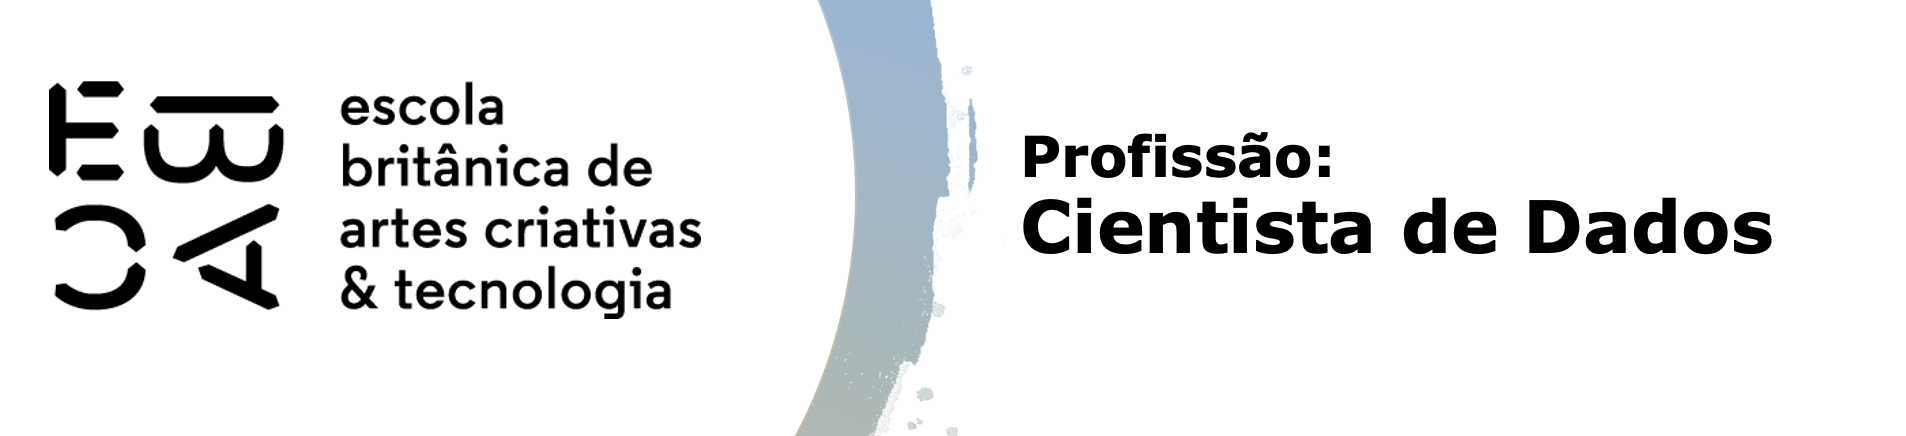

# Tarefa - Agrupamento hierárquico

Neste exercício vamos usar a base [online shoppers purchase intention](https://archive.ics.uci.edu/ml/datasets/Online+Shoppers+Purchasing+Intention+Dataset) de Sakar, C.O., Polat, S.O., Katircioglu, M. et al. Neural Comput & Applic (2018). [Web Link](https://doi.org/10.1007/s00521-018-3523-0).

A base trata de registros de 12.330 sessões de acesso a páginas, cada sessão sendo de um único usuário em um período de 12 meses, para posteriormente estudarmos a relação entre o design da página e o perfil do cliente - "Será que clientes com comportamento de navegação diferentes possuem propensão a compra diferente?"

Nosso objetivo agora é agrupar as sessões de acesso ao portal considerando o comportamento de acesso e informações da data, como a proximidade a uma data especial, fim de semana e o mês.

|Variavel                |Descrição          |
|------------------------|:-------------------|
|Administrative          | Quantidade de acessos em páginas administrativas|
|Administrative_Duration | Tempo de acesso em páginas administrativas |
|Informational           | Quantidade de acessos em páginas informativas  |
|Informational_Duration  | Tempo de acesso em páginas informativas  |
|ProductRelated          | Quantidade de acessos em páginas de produtos |
|ProductRelated_Duration | Tempo de acesso em páginas de produtos |
|BounceRates             | *Percentual de visitantes que entram no site e saem sem acionar outros *requests* durante a sessão  |
|ExitRates               | * Soma de vezes que a página é visualizada por último em uma sessão dividido pelo total de visualizações |
|PageValues              | * Representa o valor médio de uma página da Web que um usuário visitou antes de concluir uma transação de comércio eletrônico |
|SpecialDay              | Indica a proximidade a uma data festiva (dia das mães etc) |
|Month                   | Mês  |
|OperatingSystems        | Sistema operacional do visitante |
|Browser                 | Browser do visitante |
|Region                  | Região |
|TrafficType             | Tipo de tráfego                  |
|VisitorType             | Tipo de visitante: novo ou recorrente |
|Weekend                 | Indica final de semana |
|Revenue                 | Indica se houve compra ou não |

\* variávels calculadas pelo google analytics

In [26]:
# IMPORTANDO AS BIBLIOTECAS NECESSÁRIAS
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.cluster import AgglomerativeClustering
from sklearn.preprocessing import StandardScaler
from scipy.spatial.distance import pdist, squareform
from scipy.cluster.hierarchy import linkage, fcluster, dendrogram
from gower import gower_matrix
from sklearn.metrics import silhouette_score


%matplotlib inline


In [27]:
# Carregando a base de dados
df = pd.read_csv('online_shoppers_intention.csv')

In [28]:
# Verificando as primeiras linhas da base de dados
df.head()

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend,Revenue
0,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,Feb,1,1,1,1,Returning_Visitor,False,False
1,0,0.0,0,0.0,2,64.000000,0.00,0.10,0.0,0.0,Feb,2,2,1,2,Returning_Visitor,False,False
2,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,Feb,4,1,9,3,Returning_Visitor,False,False
3,0,0.0,0,0.0,2,2.666667,0.05,0.14,0.0,0.0,Feb,3,2,2,4,Returning_Visitor,False,False
4,0,0.0,0,0.0,10,627.500000,0.02,0.05,0.0,0.0,Feb,3,3,1,4,Returning_Visitor,True,False


In [29]:
# Quantidade de sessões que resultaram em receita (compra) e as que não resultaram.
# O argumento dropna=False garante que também serão contadas as entradas que possuem valores NaN.
df.Revenue.value_counts(dropna=False)

False    10422
True      1908
Name: Revenue, dtype: int64

###### **False:** Indica o número de sessões que não resultaram em uma compra. No caso, houve 10.422 sessões que *não geraram receita*.<br>
###### **True:** Indica o número de sessões que *resultaram em uma compra*. No caso, houve 1.908 sessões que geraram receita.

## 1. Análise descritiva

Faça uma análise descritiva das variáveis do escopo.
- Verifique a distribuição dessas variáveis
- Veja se há valores missing e caso haja, decida o que fazer
- Faça mais algum tratamento nas variáveis caso ache pertinente


In [30]:
# Análise descritiva
df.describe()


,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,OperatingSystems,Browser,Region,TrafficType
count,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000
mean,2.315166,80.818611,0.503569,34.472398,31.731468,1194.746220,0.022191,0.043073,5.889258,0.061427,2.124006,2.357097,3.147364,4.069586
std,3.321784,176.779107,1.270156,140.749294,44.475503,1913.669288,0.048488,0.048597,18.568437,0.198917,0.911325,1.717277,2.401591,4.025169
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000
25%,0.000000,0.000000,0.000000,0.000000,7.000000,184.137500,0.000000,0.014286,0.000000,0.000000,2.000000,2.000000,1.000000,2.000000
50%,1.000000,7.500000,0.000000,0.000000,18.000000,598.936905,0.003112,0.025156,0.000000,0.000000,2.000000,2.000000,3.000000,2.000000
75%,4.000000,93.256250,0.000000,0.000000,38.000000,1464.157214,0.016813,0.050000,0.000000,0.000000,3.000000,2.000000,4.000000,4.000000
max,27.000000,3398.750000,24.000000,2549.375000,705.000000,63973.522230,0.200000,0.200000,361.763742,1.000000,8.000000,13.000000,9.000000,20.000000


In [31]:
# Verificando se há valores missing
df.isnull().sum()

Administrative             0
Administrative_Duration    0
Informational              0
Informational_Duration     0
ProductRelated             0
ProductRelated_Duration    0
BounceRates                0
ExitRates                  0
PageValues                 0
SpecialDay                 0
Month                      0
OperatingSystems           0
Browser                    0
Region                     0
TrafficType                0
VisitorType                0
Weekend                    0
Revenue                    0
dtype: int64

In [32]:
# Número de valores distintos em cada coluna
df.nunique().to_frame()

,0
Administrative,27
Administrative_Duration,3335
Informational,17
Informational_Duration,1258
ProductRelated,311
ProductRelated_Duration,9551
BounceRates,1872
ExitRates,4777
PageValues,2704
SpecialDay,6


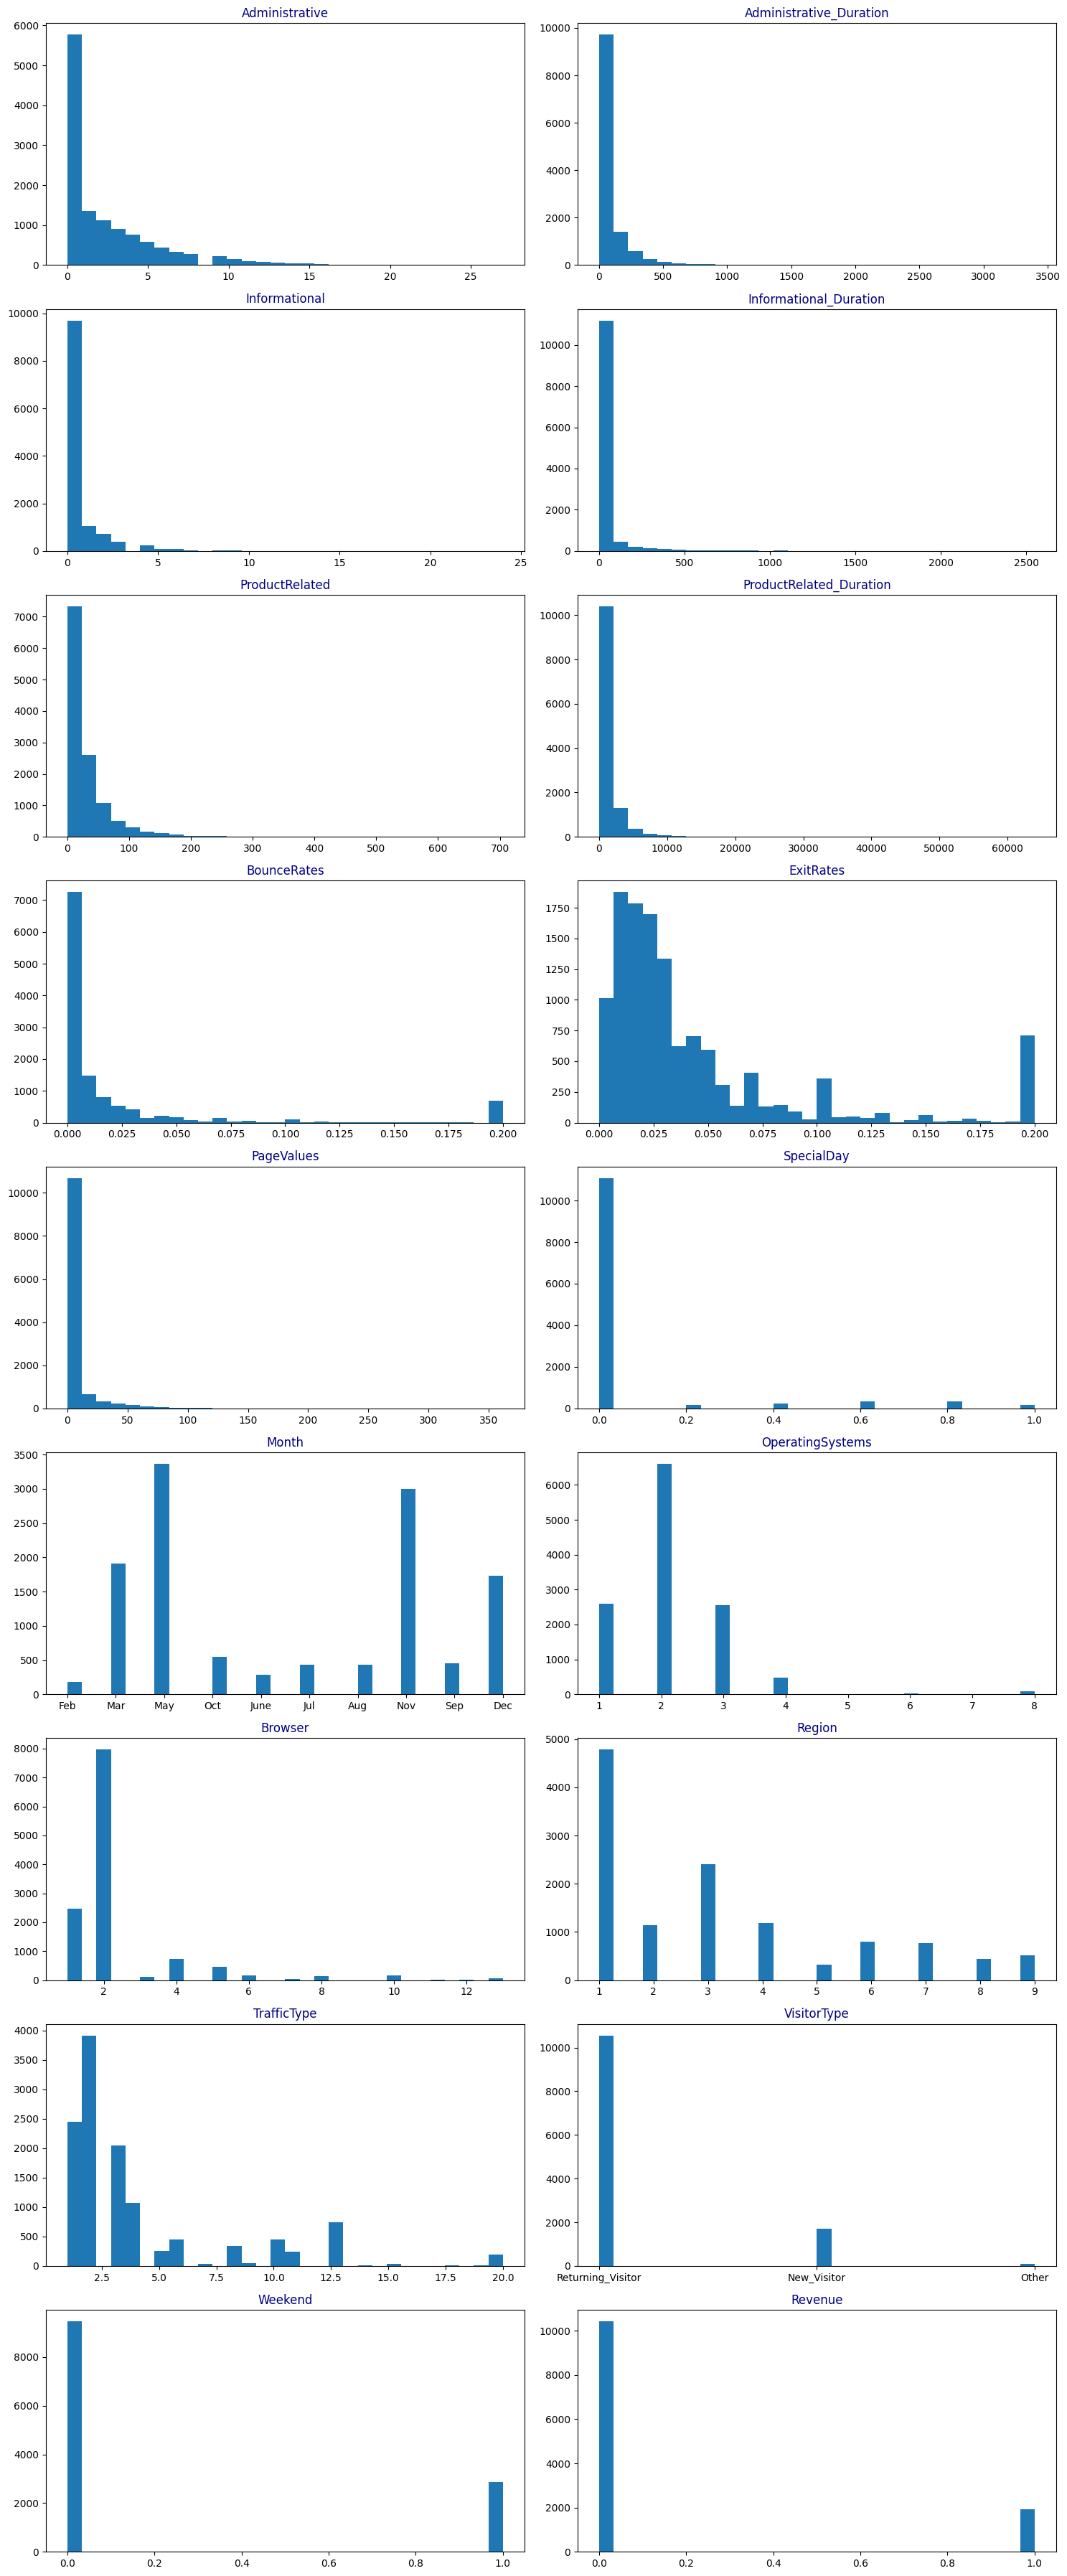

In [33]:
# Convertendo colunas booleanas para inteiros
for col in df.select_dtypes(include=['bool']).columns:
    df[col] = df[col].astype(int)

# Verificando a distribuição das variáveis
fig, axs = plt.subplots(len(df.columns)//2, 2, figsize=(15, len(df.columns)*2))

for i, column in enumerate(df.columns):
    axs[i//2, i%2].hist(df[column], bins=30)
    axs[i//2, i%2].set_title(column, color = 'navy')

plt.tight_layout()
plt.show()



## 2. Variáveis de agrupamento

Liste as variáveis que você vai querer utilizar. Essa é uma atividade importante do projeto, e tipicamente não a recebemos pronta. Não há resposta pronta ou correta, mas apenas critérios e a sua decisão. Os critérios são os seguintes:

- Selecione para o agrupamento variáveis que descrevam o padrão de navegação na sessão.
- Selecione variáveis que indiquem a característica da data.
- Não se esqueça de que você vai precisar realizar um tratamento especial para variáveis qualitativas.
- Trate adequadamente valores faltantes.

In [34]:
# Verificando as colunas
df.columns

Index(['Administrative', 'Administrative_Duration', 'Informational',
       'Informational_Duration', 'ProductRelated', 'ProductRelated_Duration',
       'BounceRates', 'ExitRates', 'PageValues', 'SpecialDay', 'Month',
       'OperatingSystems', 'Browser', 'Region', 'TrafficType', 'VisitorType',
       'Weekend', 'Revenue'],
      dtype='object')

In [35]:
variaveis = ['Administrative', 'Administrative_Duration', 'Informational', 'Informational_Duration',
             'ProductRelated', 'ProductRelated_Duration', 'BounceRates', 'ExitRates', 'PageValues','SpecialDay', 'Month', 'Weekend']

##### Para o agrupamento, as seguintes variáveis quantitativas, que descrevem o padrão de navegação na sessão serão consideradas:

*Administrative:* Quantidade de acessos em páginas administrativas.<br>
*Administrative_Duration:* Tempo de acesso em páginas administrativas.<br>
*Informational:* Quantidade de acessos em páginas informativas.<br>
*Informational_Duration:* Tempo de acesso em páginas informativas.<br>
*ProductRelated:* Quantidade de acessos em páginas de produtos.<br>
*ProductRelated_Duration:* Tempo de acesso em páginas de produtos.<br>
*BounceRates:* Percentual de visitantes que entram no site e saem sem acionar outrosrequests durante a sessão.<br>
*ExitRates:* Soma de vezes que a página é visualizada por último em uma sessão dividido pelo total de visualizações.<br>
*PageValues:* Representa o valor médio de uma página da Web que um usuário visitou antes de concluir uma transação de comércio eletrônico.

In [37]:
variaveis_qtd = ['Administrative', 'Administrative_Duration', 'Informational', 'Informational_Duration',
             'ProductRelated', 'ProductRelated_Duration', 'BounceRates', 'ExitRates', 'PageValues']

##### A variáveis quantitativas,  que indicam a característica da data,são:

*SpecialDay:* Indica a proximidade a uma data festiva (dia das mães etc).<br>
*Month:* Mês.<br>
*Weekend:* Indica final de semana.<br>

In [38]:
variaveis_cat = ['SpecialDay', 'Month', 'Weekend']

In [42]:
# Criando um novo DataFrame 'df_padrao' que contém as variáveis quantitativas padronizadas (média 0 e desvio padrão 1)
# e as variáveis categóricas originais do DataFrame 'df'.

df_padrao = pd.DataFrame(StandardScaler().fit_transform(df[variaveis_qtd]), columns = df[variaveis_qtd].columns)
df_padrao[variaveis_cat] = df[variaveis_cat]
df_padrao.head()


,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,Weekend
0,-0.696993,-0.457191,-0.396478,-0.244931,-0.691003,-0.624348,3.667189,3.229316,-0.317178,0.0,Feb,0
1,-0.696993,-0.457191,-0.396478,-0.244931,-0.668518,-0.590903,-0.457683,1.171473,-0.317178,0.0,Feb,0
2,-0.696993,-0.457191,-0.396478,-0.244931,-0.691003,-0.624348,3.667189,3.229316,-0.317178,0.0,Feb,0
3,-0.696993,-0.457191,-0.396478,-0.244931,-0.668518,-0.622954,0.573535,1.994610,-0.317178,0.0,Feb,0
4,-0.696993,-0.457191,-0.396478,-0.244931,-0.488636,-0.296430,-0.045196,0.142551,-0.317178,0.0,Feb,1


In [43]:
# Cria um novo DataFrame 'df_tratado' que contém as variáveis selecionadas do DataFrame 'df_padrao'
# com todas as variáveis categóricas convertidas em variáveis dummy e todas as linhas contendo valores NaN removidas.

df_tratado = pd.get_dummies(df_padrao[variaveis].dropna(), columns = variaveis_cat)
df_tratado.head()


,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay_0.0,...,Month_Feb,Month_Jul,Month_June,Month_Mar,Month_May,Month_Nov,Month_Oct,Month_Sep,Weekend_0,Weekend_1
0,-0.696993,-0.457191,-0.396478,-0.244931,-0.691003,-0.624348,3.667189,3.229316,-0.317178,1,...,1,0,0,0,0,0,0,0,1,0
1,-0.696993,-0.457191,-0.396478,-0.244931,-0.668518,-0.590903,-0.457683,1.171473,-0.317178,1,...,1,0,0,0,0,0,0,0,1,0
2,-0.696993,-0.457191,-0.396478,-0.244931,-0.691003,-0.624348,3.667189,3.229316,-0.317178,1,...,1,0,0,0,0,0,0,0,1,0
3,-0.696993,-0.457191,-0.396478,-0.244931,-0.668518,-0.622954,0.573535,1.994610,-0.317178,1,...,1,0,0,0,0,0,0,0,1,0
4,-0.696993,-0.457191,-0.396478,-0.244931,-0.488636,-0.296430,-0.045196,0.142551,-0.317178,1,...,1,0,0,0,0,0,0,0,0,1


## 3. Número de grupos

Nesta atividade vamos adotar uma abordagem bem pragmática e avaliar agrupamentos hierárquicos com 3 e 4 grupos, por estarem bem alinhados com uma expectativa e estratégia do diretor da empresa.

*Atenção*: Cuidado se quiser fazer o dendrograma, pois com muitas observações ele pode ser mais complicado de fazer, e dependendo de como for o comando, ele pode travar o *kernell* do seu python.

In [47]:
df_tratado.columns.values

array(['Administrative', 'Administrative_Duration', 'Informational',
       'Informational_Duration', 'ProductRelated',
       'ProductRelated_Duration', 'BounceRates', 'ExitRates',
       'PageValues', 'SpecialDay_0.0', 'SpecialDay_0.2', 'SpecialDay_0.4',
       'SpecialDay_0.6', 'SpecialDay_0.8', 'SpecialDay_1.0', 'Month_Aug',
       'Month_Dec', 'Month_Feb', 'Month_Jul', 'Month_June', 'Month_Mar',
       'Month_May', 'Month_Nov', 'Month_Oct', 'Month_Sep', 'Weekend_0',
       'Weekend_1'], dtype=object)

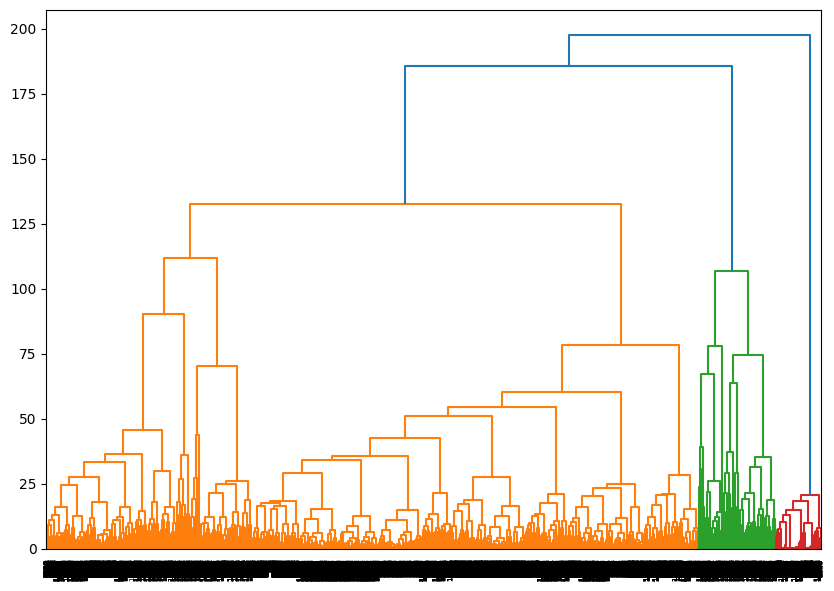

In [48]:
# Realizando o agrupamento hierárquico
linked = linkage(df_tratado, 'ward')

# Gerando o dendrograma
plt.figure(figsize=(10, 7))
dendrogram(linked, orientation='top', distance_sort='descending', show_leaf_counts=True)
plt.show()

In [49]:
# Realizando o agrupamento hierárquico com 3 grupos
cluster = AgglomerativeClustering(n_clusters=3, affinity='euclidean', linkage='ward')
cluster.fit_predict(df_tratado)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(


array([1, 0, 1, ..., 0, 0, 0])

In [50]:
# Realizando o agrupamento hierárquico com 4 grupos
cluster = AgglomerativeClustering(n_clusters=4, affinity='euclidean', linkage='ward')
cluster.fit_predict(df_tratado)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(


array([3, 1, 3, ..., 1, 0, 1])

## 4. Avaliação dos grupos

Construa os agrupamentos com a técnica adequada que vimos em aula. Não se esqueça de tratar variáveis qualitativas, padronizar escalas das quantitativas, tratar valores faltantes e utilizar a distância correta.

Faça uma análise descritiva para pelo menos duas soluções de agrupamentos (duas quantidades diferentes de grupos) sugeridas no item anterior, utilizando as variáveis que estão no escopo do agrupamento.
- Com base nesta análise e nas análises anteriores, decida pelo agrupamento final.
- Se puder, sugira nomes para os grupos.

In [55]:
# Padronização das variáveis quantitativas
scaler = StandardScaler()
df[variaveis_qtd] = scaler.fit_transform(df[variaveis_qtd])

# Tratamento de valores faltantes
df = df.dropna()

# Transformação de variáveis qualitativas em variáveis dummy
# Transformação de todas as variáveis categóricas em variáveis dummy
df = pd.get_dummies(df)


In [60]:
# Construção dos agrupamentos
for n_clusters in [3, 4]:
    clusterer = AgglomerativeClustering(n_clusters=n_clusters)
    labels = clusterer.fit_predict(df)

    # Avaliação dos agrupamentos
    silhouette_avg = silhouette_score(df, labels)
    print("Para n_clusters =", n_clusters, "o score médio do coeficiente de silhueta é :", silhouette_avg)
    print('\n')

    # Análise descritiva dos agrupamentos
    df['Cluster'] = labels
    print(df.groupby('Cluster').mean())


Para n_clusters = 3 o score médio do coeficiente de silhueta é : 0.28298754879498417


         Administrative  Administrative_Duration  Informational  \
Cluster                                                           
0             -0.067177                -0.042789      -0.082241   
1              0.010898                 0.013666       0.033696   
2              0.022941                -0.013013      -0.055533   

         Informational_Duration  ProductRelated  ProductRelated_Duration  \
Cluster                                                                    
0                     -0.097788       -0.079543                -0.059650   
1                      0.050285        0.021527                 0.014675   
2                     -0.108013       -0.008261                -0.000162   

         BounceRates  ExitRates  PageValues  OperatingSystems  ...  Month_Mar  \
Cluster                                                        ...              
0           0.153623   0.153674   

O coeficiente de silhueta médio para 3 grupos é 0.253 e para 4 grupos é 0.264.<br>
O coeficiente de silhueta varia de -1 a 1, e valores mais altos indicam que os pontos estão mais próximos do seu próprio cluster do que dos outros clusters, sugerindo um bom agrupamento.

A tabela mostra as médias das variáveis para cada cluster. Por exemplo, no agrupamento de 3 clusters, o Cluster 0 tem um valor médio de `Administrative` de -0.067, enquanto o Cluster 1 tem um valor médio de `Administrative` de 0.011 e o Cluster 2 tem um valor médio de `Administrative` de 0.023.

>Com base nesses resultados, considerando que o coeficiente de silhueta seja mais importante, o agrupamento de 4 clusters seria a melhor opção, pois tem um coeficiente de silhueta médio mais alto.



## 5. Avaliação de resultados

Avalie os grupos obtidos com relação às variáveis fora do escopo da análise (minimamente *bounce rate* e *revenue*).
- Qual grupo possui clientes mais propensos à compra?

In [61]:
# Calculando a média de 'BounceRates' e 'Revenue' para cada grupo
print(df.groupby('Cluster')['BounceRates', 'Revenue'].mean())


         BounceRates   Revenue
Cluster                       
0           0.029307  0.155880
1           0.120968  0.221719
2          -0.275241  0.138889
3           0.157608  0.159028


<ipython-input-61-6bbf0a2af517>:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  print(df.groupby('Cluster')['BounceRates', 'Revenue'].mean())


Os resultados mostram a média de `BounceRates` e `Revenue` para cada grupo (Cluster 0, 1, 2 e 3).

- O **Cluster 0** tem uma taxa média de rejeição (BounceRates) de 0.029 e uma proporção média de sessões que resultaram em uma compra (Revenue) de 0.156.
- O **Cluster 1** tem uma taxa média de rejeição de 0.121 e uma proporção média de sessões que resultaram em uma compra de 0.222.
- O **Cluster 2** tem uma taxa média de rejeição de -0.275 e uma proporção média de sessões que resultaram em uma compra de 0.139.
- O **Cluster 3** tem uma taxa média de rejeição de 0.158 e uma proporção média de sessões que resultaram em uma compra de 0.159.

>Com base nesses resultados, o grupo com clientes mais propensos à compra seria o **Cluster 1**, pois tem o maior valor médio para `Revenue` (0.222). Isso significa que, em média, 22.2% das sessões neste grupo resultaram em uma compra.
